In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
from xgboost import XGBClassifier

warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)

In [3]:
# 1. 데이터 불러오기
df = pd.read_csv("/content/건강검진 (1).csv")

In [5]:
df

,YEAR,ID,SEX,AGE_GROUP,SIDO,HEIGHT,WEIGHT,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,TRIGLYCERIDE,HDL_CHOLE,LDL_CHOLE,HMG,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT_TYPE_CD,DRK_YN,BMI,OBESITY,DYSLIPIDEMIA,DIABETES,HYPERTENSION,LIVER_ABNORMAL,KIDNEY_ABNORMAL,ANEMIA
0,2017,1,1,8,43,170,75,90.0,120,80,99,193.0,92.0,48.0,126.0,17.1,1,1.0,21.0,35.0,40.0,1,1,26.0,class1,False,normal,pre,False,False,False
1,2017,2,1,7,11,180,80,89.0,130,82,106,228.0,121.0,55.0,148.0,15.8,1,0.9,20.0,36.0,27.0,3,0,24.7,pre,False,pre,pre,False,False,False
2,2017,3,1,9,41,165,75,91.0,120,70,98,136.0,104.0,41.0,74.0,15.8,1,0.9,47.0,32.0,68.0,1,0,27.5,class1,False,normal,pre,True,False,False
3,2017,4,1,11,48,175,80,91.0,145,87,95,201.0,106.0,76.0,104.0,17.6,1,1.1,29.0,34.0,18.0,1,0,26.1,class1,False,normal,stage1,False,False,False
4,2017,5,1,11,30,165,60,80.0,138,82,101,199.0,104.0,61.0,117.0,13.8,1,0.8,19.0,12.0,25.0,1,0,22.0,normal,False,pre,pre,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2386508,2022,2134210,1,6,43,170,90,98.8,128,84,88,245.0,150.0,35.0,180.0,15.8,1,0.9,95.0,251.0,77.0,1,1,31.1,class2,True,normal,pre,True,False,False
2386509,2022,1686113,2,15,27,150,85,116.0,136,81,134,240.0,108.0,73.0,145.0,12.4,1,1.4,59.0,49.0,25.0,1,0,37.8,class3,True,diabetes,pre,True,False,False
2386510,2022,902951,1,12,45,165,80,98.2,119,83,181,205.0,191.0,47.0,120.0,15.7,1,1.0,48.0,82.0,60.0,2,1,29.4,class1,False,diabetes,pre,True,False,False
2386511,2022,3721315,1,6,47,175,65,75.4,109,60,91,178.0,61.0,54.0,112.0,13.7,1,1.1,245.0,72.0,17.0,2,1,21.2,normal,False,normal,normal,True,False,False


In [8]:
df["Year_ID"] = df["YEAR"].astype(str) + "_" + df["ID"].astype(str)
cols = ['Year_ID'] + [col for col in df.columns if col != 'Year_ID']
df = df[cols]
df = df.drop(['ID', 'YEAR'], axis=1)

In [9]:
# 2. 라벨 맵핑
df['OBESITY'] = df['OBESITY'].map({'normal': 0, 'pre': 1, 'class1': 2, 'class2': 3, 'class3': 4})
df['DIABETES'] = df['DIABETES'].map({'normal': 0, 'pre': 1, 'diabetes': 2})
df['HYPERTENSION'] = df['HYPERTENSION'].map({'normal': 0, 'pre': 1, 'stage1': 2, 'stage2': 3})
binary_cols = ['DYSLIPIDEMIA', 'LIVER_ABNORMAL', 'KIDNEY_ABNORMAL', 'ANEMIA']
for col in binary_cols:
    df[col] = df[col].map({False: 0, True: 1})

In [14]:
df.head()

,Year_ID,SEX,AGE_GROUP,SIDO,HEIGHT,WEIGHT,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,TRIGLYCERIDE,HDL_CHOLE,LDL_CHOLE,HMG,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT_TYPE_CD,DRK_YN,BMI,OBESITY,DYSLIPIDEMIA,DIABETES,HYPERTENSION,LIVER_ABNORMAL,KIDNEY_ABNORMAL,ANEMIA
0,2017_1,1,8,43,0.333333,0.666667,0.615385,-0.105263,0.333333,0.117647,-0.039216,-0.180723,-0.368421,0.270833,1.227273,0.0,0.666667,-0.2,0.8750,0.666667,1,1,0.456522,2,0,0,1,0,0,0
1,2017_2,1,7,11,1.000000,1.000000,0.538462,0.421053,0.500000,0.529412,0.647059,0.168675,0.000000,0.729167,0.636364,0.0,0.333333,-0.3,0.9375,0.125000,3,0,0.173913,1,0,1,1,0,0,0
2,2017_3,1,9,41,0.000000,0.666667,0.692308,-0.105263,-0.500000,0.058824,-1.156863,-0.036145,-0.736842,-0.812500,0.636364,0.0,0.333333,2.4,0.6875,1.833333,1,0,0.782609,2,0,0,1,1,0,0
3,2017_4,1,11,48,0.666667,1.000000,0.692308,1.210526,0.916667,-0.117647,0.117647,-0.012048,1.105263,-0.187500,1.454545,0.0,1.000000,0.6,0.8125,-0.250000,1,0,0.478261,2,0,0,2,0,0,0
4,2017_5,1,11,30,0.000000,-0.333333,-0.153846,0.842105,0.500000,0.235294,0.078431,-0.036145,0.315789,0.083333,-0.272727,0.0,0.000000,-0.4,-0.5625,0.041667,1,0,-0.413043,0,0,1,1,0,0,0


In [15]:
df.isnull().sum()

,0
Year_ID,0
SEX,0
AGE_GROUP,0
SIDO,0
HEIGHT,0
WEIGHT,0
WAIST,0
BP_HIGH,0
BP_LWST,0
BLDS,0


In [16]:
# 3. 입력 변수 정의 및 정규화 (연속형 변수만)
input_features = ["HEIGHT", "WEIGHT", "WAIST", "BP_HIGH", "BP_LWST",
                  "BLDS", "TOT_CHOLE", "TRIGLYCERIDE", "HDL_CHOLE",
                  "LDL_CHOLE", "HMG", "OLIG_PROTE_CD", "CREATININE",
                  "SGOT_AST", "SGPT_ALT", "GAMMA_GTP"]

scaler = RobustScaler()
df[input_features] = scaler.fit_transform(df[input_features])

#질병 간 상관관계

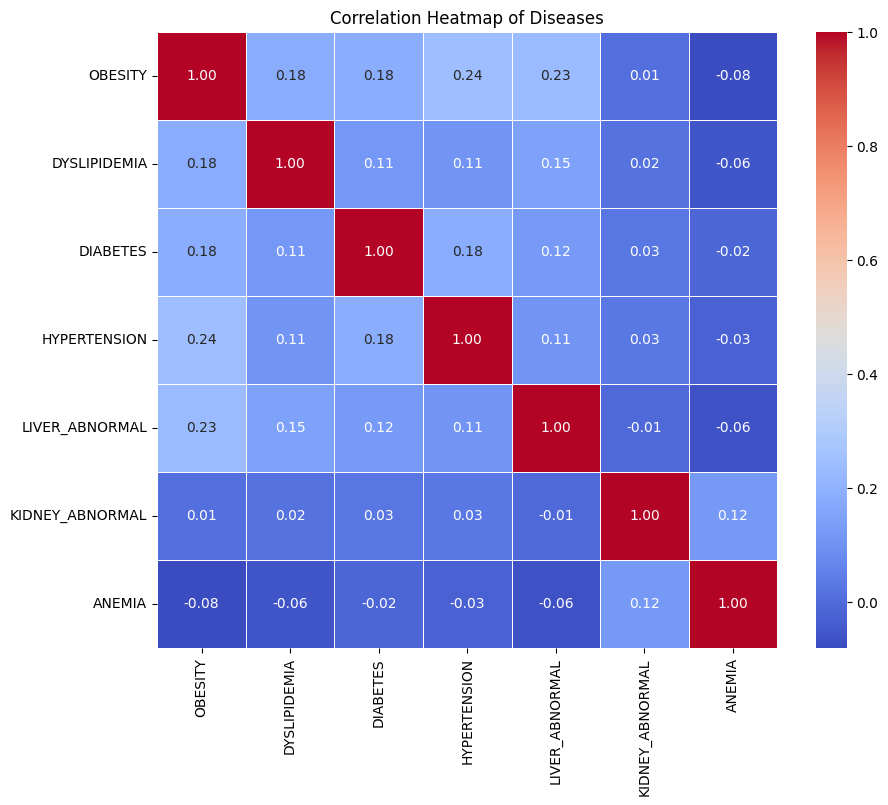

In [17]:
# 상관관계 분석을 위한 질병 관련 컬럼 리스트
disease_columns = ['OBESITY', 'DYSLIPIDEMIA', 'DIABETES', 'HYPERTENSION',
                   'LIVER_ABNORMAL', 'KIDNEY_ABNORMAL', 'ANEMIA']

# 선택된 질병 컬럼으로만 이루어진 새로운 DataFrame 생성 (결측치 처리)
df_disease = df[disease_columns].dropna()

# 상관관계 행렬 계산
correlation_matrix = df_disease.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Diseases')
plt.show()

#비만 단계 정보 제공

In [18]:
def calculate_bmi(height_cm, weight_kg):
    """키(cm)와 몸무게(kg)를 이용하여 BMI를 계산합니다."""
    if height_cm <= 0:
        return None
    height_m = height_cm / 100.0
    bmi = weight_kg / (height_m ** 2)
    return bmi

def get_obesity_level(bmi):
    """BMI 값에 따라 비만 단계를 분류합니다."""
    if bmi is None:
        return "키 정보가 없어 BMI를 계산할 수 없습니다."
    elif bmi < 23.0:
        return "정상"
    elif 23.0 <= bmi < 25.0:
        return "비만전단계"
    elif 25.0 <= bmi < 30.0:
        return "1단계 비만"
    elif 30.0 <= bmi < 35.0:
        return "2단계 비만"
    else:
        return "3단계 비만(고도 비만)"

def get_user_health_info(input_features):
    """사용자로부터 건강 정보를 입력받아 딕셔너리 형태로 반환합니다."""
    user_info = {}
    for feature in input_features:
        while True:
            try:
                value = input(f"{feature} 값을 입력하세요: ")
                # 숫자형 데이터는 float으로 변환 시도
                if feature in ["HEIGHT", "WEIGHT", "WAIST", "BP_HIGH", "BP_LWST",
                               "BLDS", "TOT_CHOLE", "TRIGLYCERIDE", "HDL_CHOLE",
                               "LDL_CHOLE", "HMG", "CREATININE",
                               "SGOT_AST", "SGPT_ALT", "GAMMA_GTP", "BMI"]:
                    user_info[feature] = float(value)
                else:
                    user_info[feature] = value
                break
            except ValueError:
                print("잘못된 입력입니다. 숫자를 입력해주세요.")
            except Exception as e:
                user_info[feature] = value
                break # 숫자 변환 실패 시 문자열로 저장하고 넘어감
    return user_info

# 정의된 input_features 리스트
input_features = ["HEIGHT", "WEIGHT", "WAIST", "BP_HIGH", "BP_LWST",
                    "BLDS", "TOT_CHOLE", "TRIGLYCERIDE", "HDL_CHOLE",
                    "LDL_CHOLE", "HMG", "OLIG_PROTE_CD", "CREATININE",
                    "SGOT_AST", "SGPT_ALT", "GAMMA_GTP", "SMK_STAT_TYPE_CD",
                    "DRK_YN","BMI"] # OLIG_PROTE_CD, SMK_STAT_TYPE_CD, DRK_YN 추가

# 사용자로부터 건강 정보 입력받기
user_health_data = get_user_health_info(input_features)

# BMI 계산
user_bmi = calculate_bmi(user_health_data.get("HEIGHT"), user_health_data.get("WEIGHT"))

# 비만 단계 확인 및 출력
obesity_level = get_obesity_level(user_bmi)

print("\n입력하신 정보를 바탕으로 BMI를 계산한 결과,")
if user_bmi:
    print(f"당신의 BMI는 {user_bmi:.2f} kg/㎡ 이며,")
print(f"비만도는 '{obesity_level}' 단계에 해당합니다.")

HEIGHT 값을 입력하세요: 180
WEIGHT 값을 입력하세요: 80
WAIST 값을 입력하세요: 90
BP_HIGH 값을 입력하세요: 120
BP_LWST 값을 입력하세요: 90
BLDS 값을 입력하세요: 0
TOT_CHOLE 값을 입력하세요: 
잘못된 입력입니다. 숫자를 입력해주세요.
TOT_CHOLE 값을 입력하세요: 
잘못된 입력입니다. 숫자를 입력해주세요.
TOT_CHOLE 값을 입력하세요: 
잘못된 입력입니다. 숫자를 입력해주세요.
TOT_CHOLE 값을 입력하세요: 
잘못된 입력입니다. 숫자를 입력해주세요.
TOT_CHOLE 값을 입력하세요: 
잘못된 입력입니다. 숫자를 입력해주세요.
TOT_CHOLE 값을 입력하세요: 0
TRIGLYCERIDE 값을 입력하세요: 0
HDL_CHOLE 값을 입력하세요: 0
LDL_CHOLE 값을 입력하세요: 0
HMG 값을 입력하세요: 0
OLIG_PROTE_CD 값을 입력하세요: 0
CREATININE 값을 입력하세요: 0
SGOT_AST 값을 입력하세요: 0
SGPT_ALT 값을 입력하세요: 0
GAMMA_GTP 값을 입력하세요: 0
SMK_STAT_TYPE_CD 값을 입력하세요: 0
DRK_YN 값을 입력하세요: 0
BMI 값을 입력하세요: 26

입력하신 정보를 바탕으로 BMI를 계산한 결과,
당신의 BMI는 24.69 kg/㎡ 이며,
비만도는 '비만전단계' 단계에 해당합니다.


#AGE_GROUP으로 학습된 KMeans 모델을 사용하여 사용자가 어떤 군집에 속하는지 예측

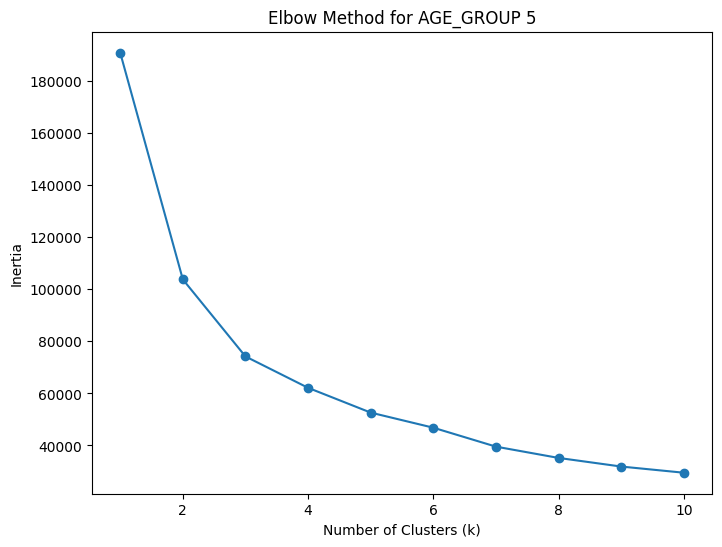

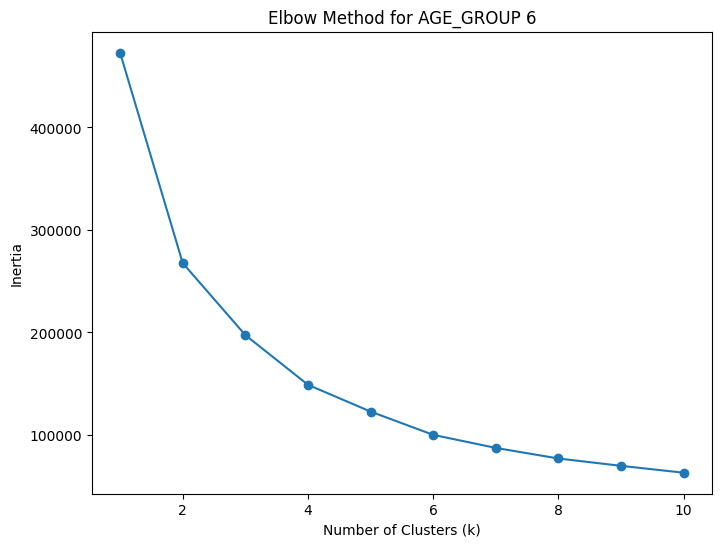

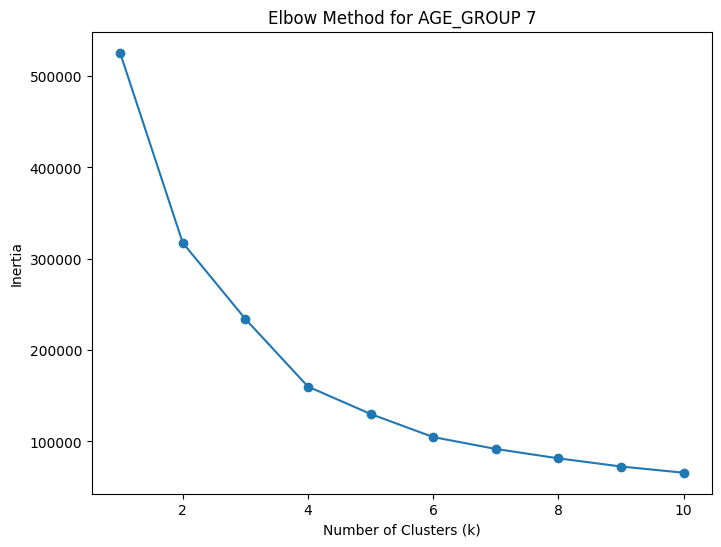

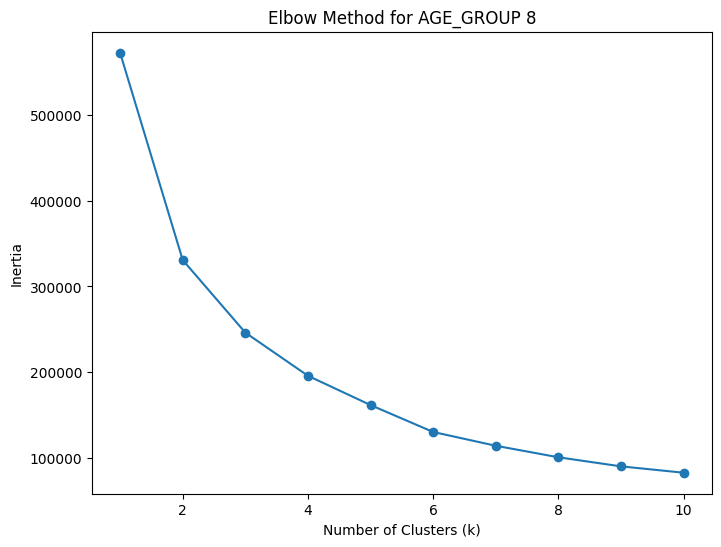

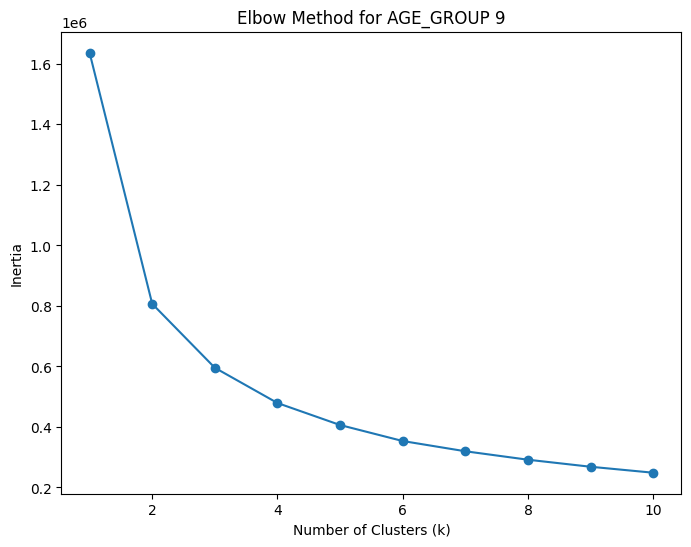

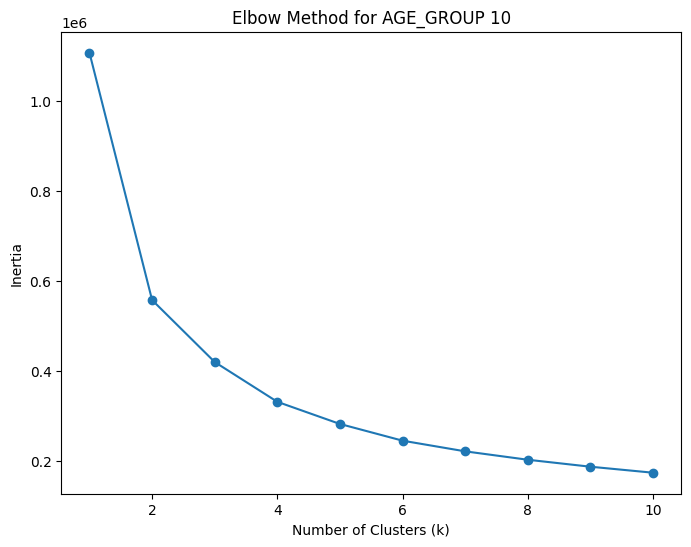

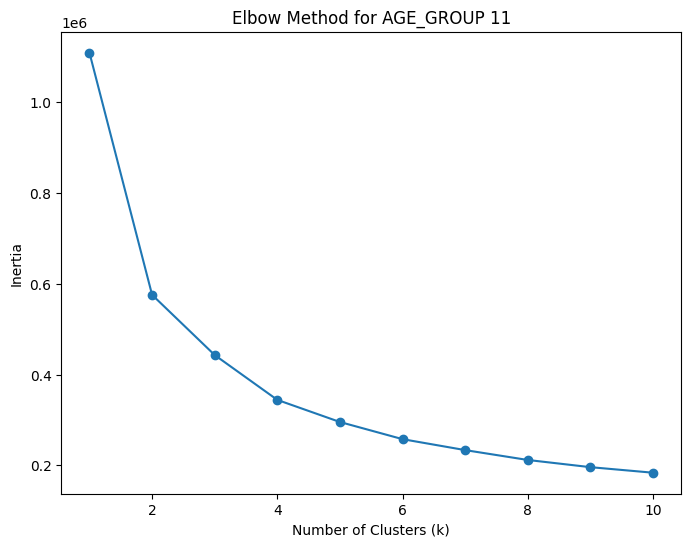

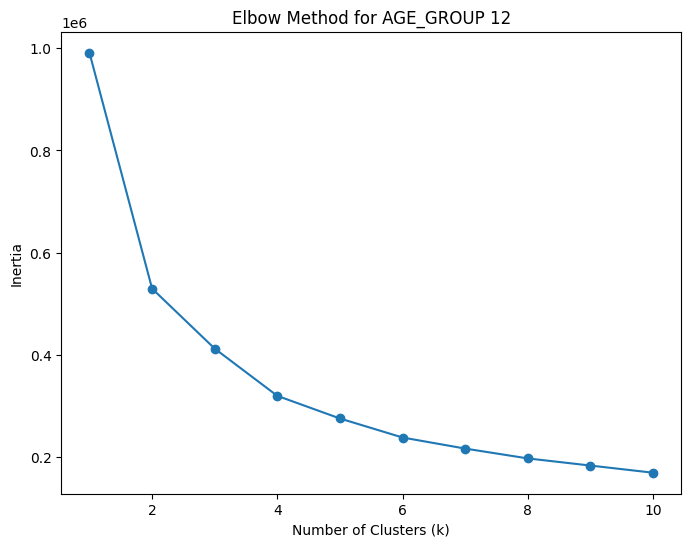

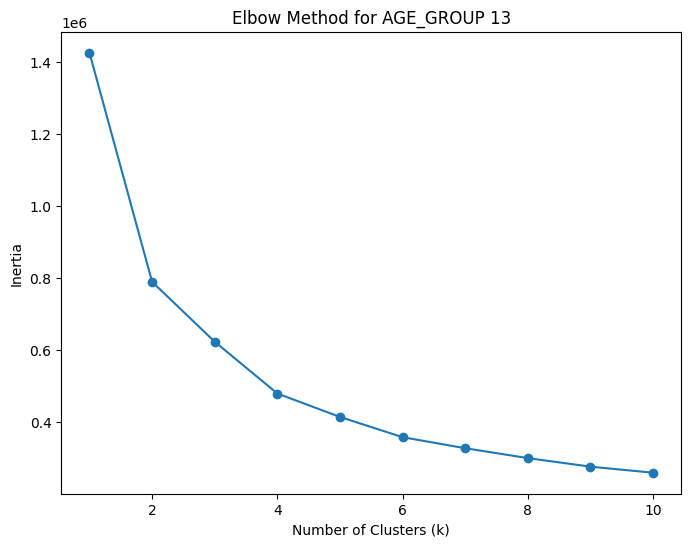

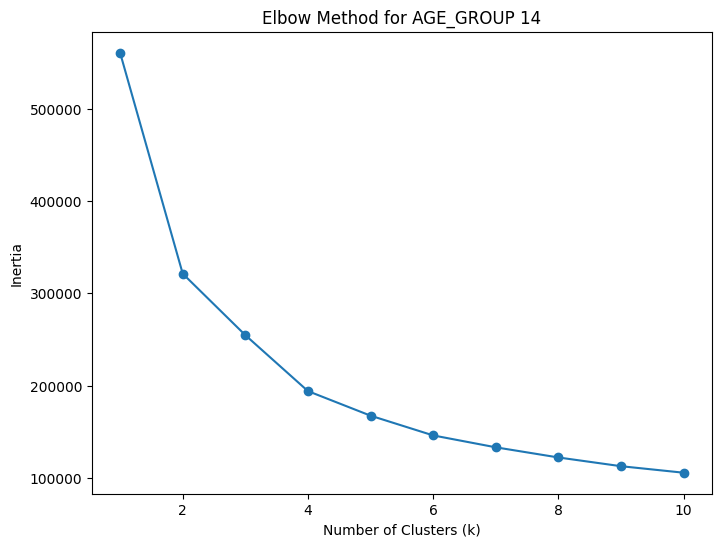

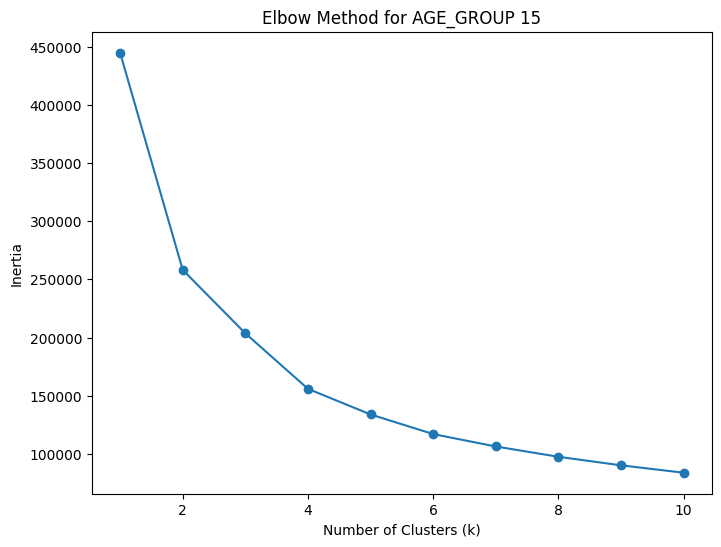

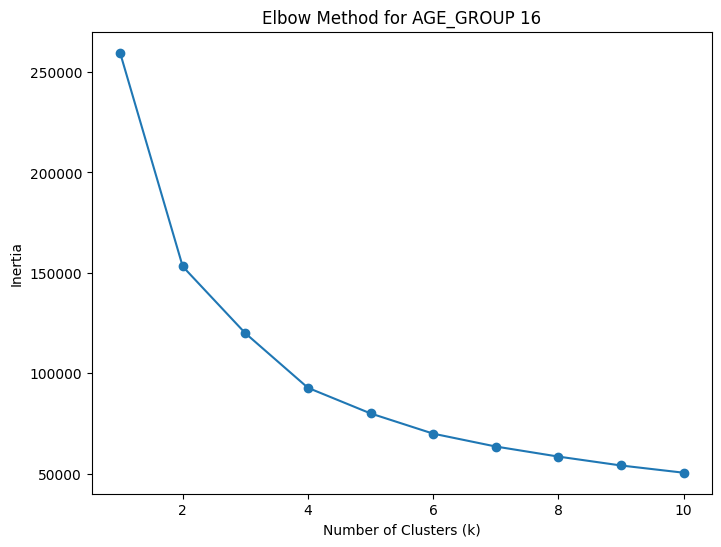

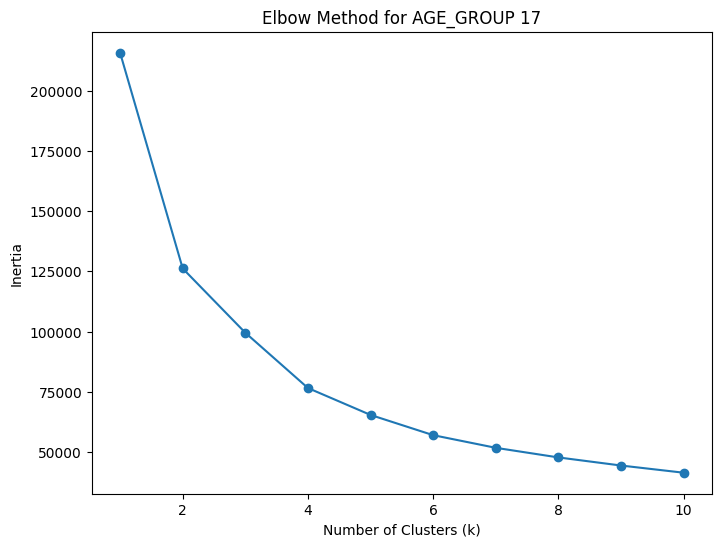

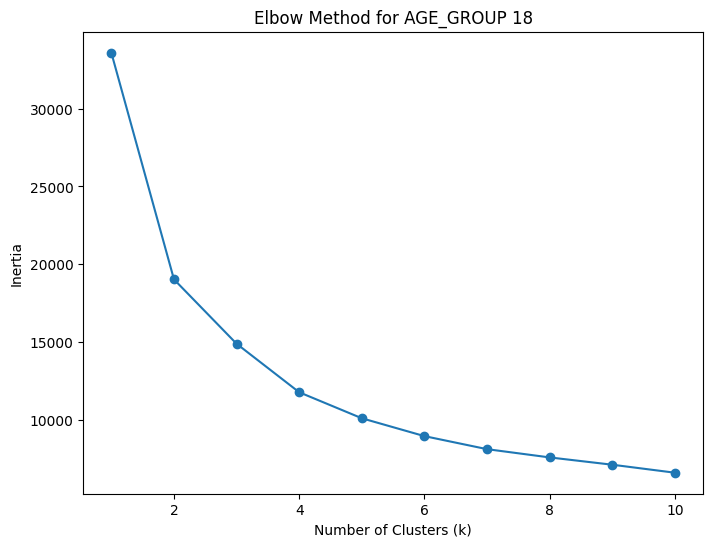

<Figure size 640x480 with 0 Axes>

In [19]:
# AGE 그룹별 데이터 그룹화
age_groups = df.groupby('AGE_GROUP')

# 시각화 결과 저장 리스트
results_df = []
all_inertia = {}

for age_group, data in age_groups:
    # 군집화에 사용할 특징
    features = ['BMI', 'WAIST', 'WEIGHT', 'HEIGHT']
    X = data[features].dropna()

    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 최적의 k 찾기 (엘보우 메서드)
    inertia = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
    all_inertia[age_group] = inertia

    # 엘보우 플롯 (각 연령대별로 표시)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 11), inertia, marker='o')
    plt.title(f'Elbow Method for AGE_GROUP {age_group}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.show()

    optimal_k_values = {
        data['AGE_GROUP'].iloc[0]: np.random.randint(2, 5)
        for age in data['AGE_GROUP'].unique()
    }
    optimal_k = optimal_k_values.get(age_group, 3) # 기본값 3

    # KMeans 군집화 적용 (최적의 k 사용)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    data['cluster'] = clusters
    results_df.append(data)

df_clustered = pd.concat(results_df)

plt.tight_layout()
plt.show()

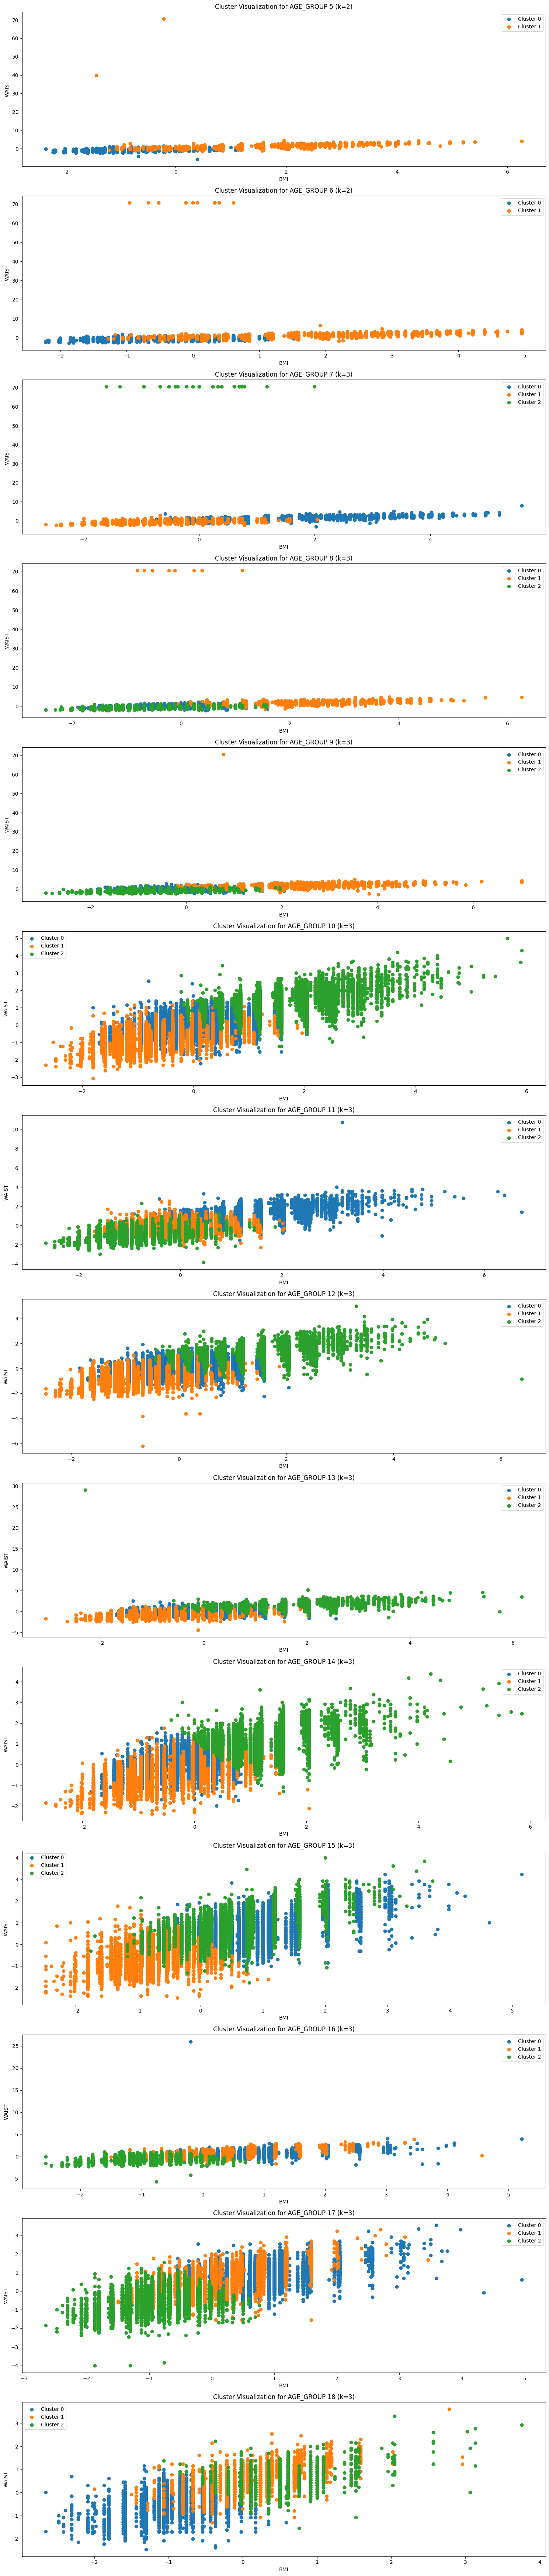

In [21]:
from sklearn.cluster import KMeans

# 각 연령대에 대한 사용자가 지정한 최적 k 값 리스트 (연령대 순서대로)
# 실제 연령대 순서와 개수에 맞춰 k 값을 지정
user_defined_k_values = {
    5: 2,  # AGE_GROUP 5에 대한 최적 k 값 (위에 그래프 보고 결정한 값)
    6: 2,
    7: 3,
    8: 3,
    9: 3,
    10: 3,
    11: 3,
    12: 3,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 3,
    18: 3
}

# AGE 그룹별 데이터 그룹화
age_groups = df.groupby('AGE_GROUP')

# 시각화 결과 저장 리스트
results_df = []

for age_group, data in age_groups:
    # 군집화에 사용할 특징
    features = ['BMI', 'WAIST', 'WEIGHT', 'HEIGHT']
    X = data[features].dropna()

    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 사용자가 지정한 최적 k 값 가져오기
    optimal_k = user_defined_k_values.get(age_group, 3)  # 해당 연령대의 k 값 가져오기, 없으면 기본값 3

    # KMeans 군집화 적용 (최적의 k 사용)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    data['cluster'] = clusters
    results_df.append(data)

df_clustered = pd.concat(results_df)

# 군집 결과 시각화 (각 연령대별로 BMI vs WAIST)
unique_age_groups = sorted(df_clustered['AGE_GROUP'].unique())
num_age_groups = len(unique_age_groups)
plt.figure(figsize=(15, 5 * num_age_groups))

for i, age_group in enumerate(unique_age_groups):
    ax = plt.subplot(num_age_groups, 1, i + 1)
    data_group = df_clustered[df_clustered['AGE_GROUP'] == age_group]
    optimal_k_for_group = user_defined_k_values.get(age_group, 3)  # 해당 연령대의 최적 k 값 가져오기
    for cluster in range(optimal_k_for_group):
        cluster_data = data_group[data_group['cluster'] == cluster]
        ax.scatter(cluster_data['BMI'], cluster_data['WAIST'], label=f'Cluster {cluster}')
    ax.set_title(f'Cluster Visualization for AGE_GROUP {age_group} (k={optimal_k_for_group})')
    ax.set_xlabel('BMI')
    ax.set_ylabel('WAIST')
    ax.legend()

plt.tight_layout()
plt.show()

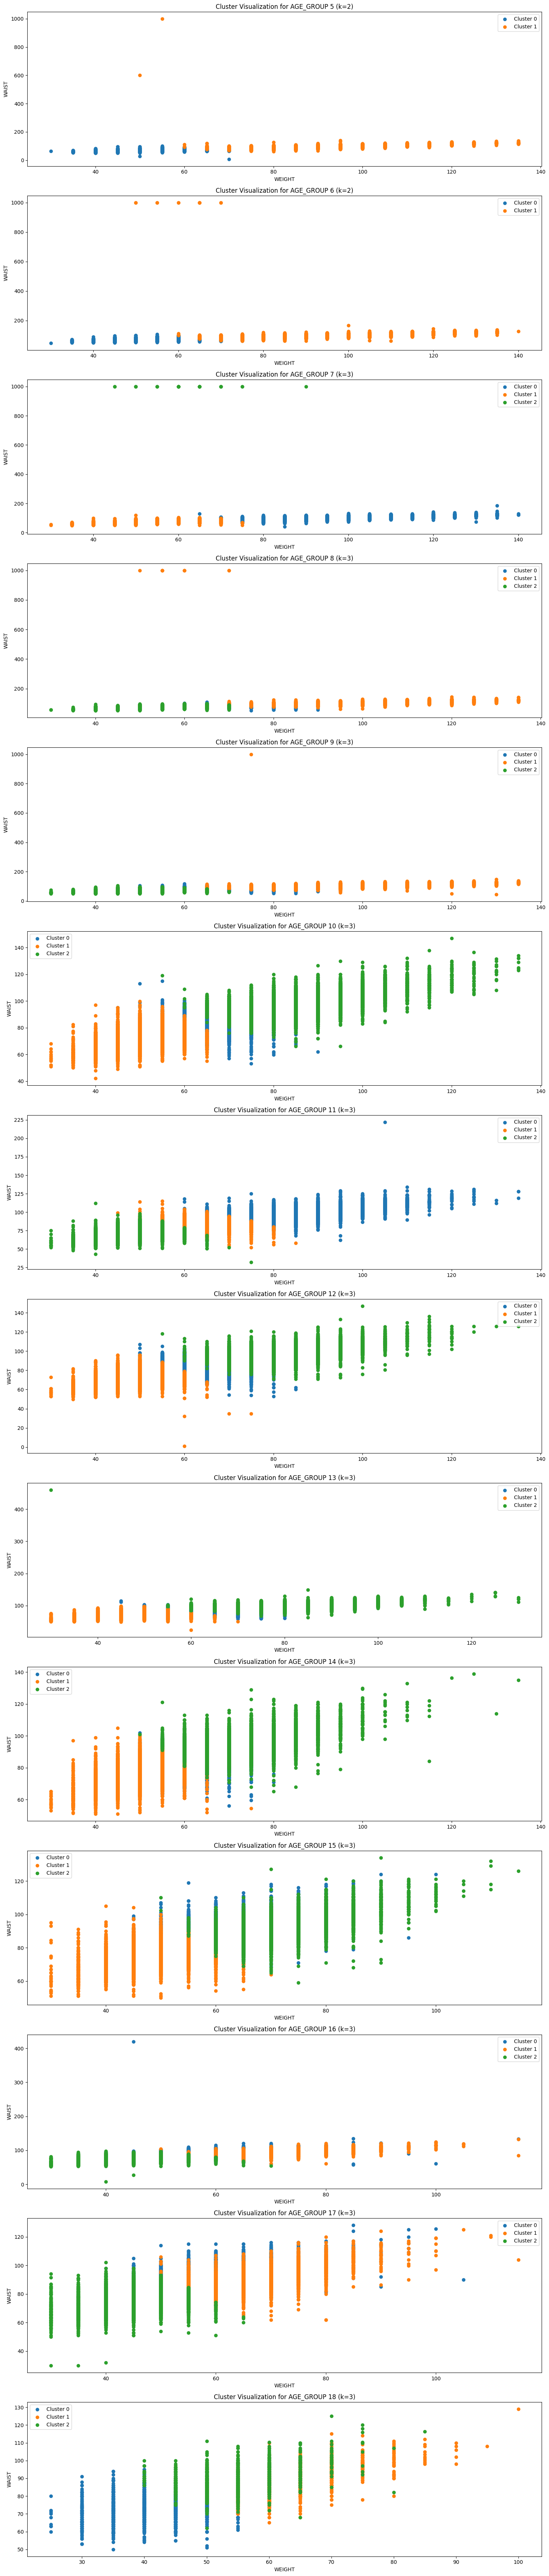

In [5]:
user_defined_k_values = {
    5: 2,  # AGE_GROUP 5에 대한 최적 k 값 (위에 그래프 보고 결정한 값)
    6: 2,
    7: 3,
    8: 3,
    9: 3,
    10: 3,
    11: 3,
    12: 3,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 3,
    18: 3
}

# AGE 그룹별 데이터 그룹화
age_groups = df.groupby('AGE_GROUP')

# 시각화 결과 저장 리스트
results_df = []

for age_group, data in age_groups:
    # 군집화에 사용할 특징
    features = ['BMI', 'WAIST', 'WEIGHT', 'HEIGHT']
    X = data[features].dropna()

    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 사용자가 지정한 최적 k 값 가져오기
    optimal_k = user_defined_k_values.get(age_group, 3)  # 해당 연령대의 k 값 가져오기, 없으면 기본값 3

    # KMeans 군집화 적용 (최적의 k 사용)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    data['cluster'] = clusters
    results_df.append(data)

df_clustered = pd.concat(results_df)

# 군집 결과 시각화 (각 연령대별로 BMI vs WAIST)
unique_age_groups = sorted(df_clustered['AGE_GROUP'].unique())
num_age_groups = len(unique_age_groups)
plt.figure(figsize=(15, 5 * num_age_groups))

for i, age_group in enumerate(unique_age_groups):
    ax = plt.subplot(num_age_groups, 1, i + 1)
    data_group = df_clustered[df_clustered['AGE_GROUP'] == age_group]
    optimal_k_for_group = user_defined_k_values.get(age_group, 3)  # 해당 연령대의 최적 k 값 가져오기
    for cluster in range(optimal_k_for_group):
        cluster_data = data_group[data_group['cluster'] == cluster]
        ax.scatter(cluster_data['WEIGHT'], cluster_data['WAIST'], label=f'Cluster {cluster}')
    ax.set_title(f'Cluster Visualization for AGE_GROUP {age_group} (k={optimal_k_for_group})')
    ax.set_xlabel('WEIGHT')
    ax.set_ylabel('WAIST')
    ax.legend()

plt.tight_layout()
plt.show()

In [20]:
user_defined_k_values = {
    5: 2,
    6: 2,
    7: 3,
    8: 3,
    9: 3,
    10: 3,
    11: 3,
    12: 3,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 3,
    18: 3
}

def calculate_bmi(height_cm, weight_kg):
    """키(cm)와 몸무게(kg)를 이용하여 BMI를 계산합니다."""
    if height_cm <= 0:
        return None
    height_m = height_cm / 100.0
    bmi = weight_kg / (height_m ** 2)
    return bmi

def get_obesity_level(bmi):
    """BMI 값에 따라 비만 단계를 분류합니다."""
    if bmi is None:
        return "키 정보가 없어 BMI를 계산할 수 없습니다."
    elif bmi < 23.0:
        return "정상"
    elif 23.0 <= bmi < 25.0:
        return "비만전단계"
    elif 25.0 <= bmi < 30.0:
        return "1단계 비만"
    elif 30.0 <= bmi < 35.0:
        return "2단계 비만"
    else:
        return "3단계 비만(고도 비만)"

def predict_cluster(user_age_group, user_bmi, user_waist, df):
    """사용자의 정보를 기반으로 속한 군집을 예측합니다."""
    age_group_data = df[df['AGE_GROUP'] == user_age_group].copy()
    if age_group_data.empty:
        return None

    features = ['BMI', 'WAIST']  # 예측에 사용할 특징만 포함
    X = age_group_data[features].dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    optimal_k = user_defined_k_values.get(user_age_group, 3)
    kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_model.fit(X_scaled)

    user_data = pd.DataFrame([{'BMI': user_bmi, 'WAIST': user_waist}])
    user_data_scaled = scaler.transform(user_data[features])
    if pd.isna(user_data_scaled).any():
        print("경고: 사용자 입력에 NaN이 포함되어 예측 결과가 정확하지 않을 수 있습니다.")
        return None # NaN이 있으면 예측 불가 처리 또는 다른 방식 고려

    predicted_cluster = kmeans_model.predict(user_data_scaled)[0]
    return predicted_cluster

def generate_report(user_age_group, user_bmi, user_waist, predicted_cluster, df_clustered):
    """군집 분석 결과를 기반으로 사용자 보고서를 생성합니다."""
    cluster_data = df_clustered[(df_clustered['AGE_GROUP'] == user_age_group) & (df_clustered['cluster'] == predicted_cluster)]

    if cluster_data.empty:
        return "해당 군집에 대한 정보가 부족합니다."

    avg_bmi = cluster_data['BMI'].mean()
    avg_waist = cluster_data['WAIST'].mean()
    obesity_rate = cluster_data['OBESITY'].mean() * 100 if 'OBESITY' in cluster_data.columns else '정보 없음'
    dyslipidemia_rate = cluster_data['DYSLIPIDEMIA'].mean() * 100 if 'DYSLIPIDEMIA' in cluster_data.columns else '정보 없음'
    diabetes_rate = cluster_data['DIABETES'].mean() * 100 if 'DIABETES' in cluster_data.columns else '정보 없음'

    obesity_level = get_obesity_level(user_bmi)

    report = f"현재 당신의 BMI는 {user_bmi:.2f} kg/㎡ 로, {obesity_level}에 해당합니다.\n\n"
    report += f"입력하신 정보를 바탕으로 분석한 결과, 당신은 AGE_GROUP {user_age_group}의 {predicted_cluster}번 군집에 속하는 것으로 나타났습니다.\n\n"
    report += f"이 군집에 속한 사람들은 평균적으로 BMI가 {avg_bmi:.2f} 정도이며, 허리 둘레는 {avg_waist:.2f} cm 내외입니다. "
    if user_waist > avg_waist:
        report += "당신의 허리 둘레는 평균보다 높은 편이므로 주의가 필요합니다.\n\n"
    elif user_waist < avg_waist:
        report += "당신의 허리 둘레는 평균보다 낮은 편입니다.\n\n"
    else:
        report += "당신의 허리 둘레는 평균과 비슷한 수준입니다.\n\n"

    report += "이 군집의 질병 발생 확률을 살펴보면,\n"
    report += f"- 비만 발생률: {obesity_rate}\n"
    report += f"- 고지혈증 발생률: {dyslipidemia_rate}\n"
    report += f"- 당뇨병 발생률: {diabetes_rate}\n\n"
    report += "따라서 비슷한 건강 상태를 가진 사람들은 이러한 질병에 걸릴 위험이 있으니 건강 관리에 유의하시기 바랍니다."

    return report

# 사용자로부터 정보 입력 받기
user_age = int(input("당신의 AGE_GROUP을 입력하세요: "))
user_height = float(input("당신의 키(cm)를 입력하세요: "))
user_weight = float(input("당신의 몸무게(kg)를 입력하세요: "))
user_waist = float(input("당신의 허리 둘레(cm)를 입력하세요: "))

# BMI 계산
user_bmi = calculate_bmi(user_height, user_weight)

# 군집 예측
predicted_cluster = predict_cluster(user_age, user_bmi, user_waist, df)

if predicted_cluster is not None:
    # 보고서 생성 및 출력
    report = generate_report(user_age, user_bmi, user_waist, predicted_cluster, df_clustered)
    print(report)
else:
    print(f"AGE_GROUP {user_age}에 대한 군집 분석 정보가 없습니다.")

당신의 AGE_GROUP을 입력하세요: 10
당신의 키(cm)를 입력하세요: 178
당신의 몸무게(kg)를 입력하세요: 98
당신의 허리 둘레(cm)를 입력하세요: 100
현재 당신의 BMI는 30.93 kg/㎡ 로, 2단계 비만에 해당합니다.

입력하신 정보를 바탕으로 분석한 결과, 당신은 AGE_GROUP 10의 0번 군집에 속하는 것으로 나타났습니다.

이 군집에 속한 사람들은 평균적으로 BMI가 -0.73 정도이며, 허리 둘레는 -0.90 cm 내외입니다. 당신의 허리 둘레는 평균보다 높은 편이므로 주의가 필요합니다.

이 군집의 질병 발생 확률을 살펴보면,
- 비만 발생률: 4.01066615185994
- 고지혈증 발생률: 17.584671629725264
- 당뇨병 발생률: 24.564726891009787

따라서 비슷한 건강 상태를 가진 사람들은 이러한 질병에 걸릴 위험이 있으니 건강 관리에 유의하시기 바랍니다.


In [21]:
df.head()

,Year_ID,SEX,AGE_GROUP,SIDO,HEIGHT,WEIGHT,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,TRIGLYCERIDE,HDL_CHOLE,LDL_CHOLE,HMG,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT_TYPE_CD,DRK_YN,BMI,OBESITY,DYSLIPIDEMIA,DIABETES,HYPERTENSION,LIVER_ABNORMAL,KIDNEY_ABNORMAL,ANEMIA
0,2017_1,1,8,43,0.333333,0.666667,0.615385,-0.105263,0.333333,0.117647,-0.039216,-0.180723,-0.368421,0.270833,1.227273,0.0,0.666667,-0.2,0.8750,0.666667,1,1,0.456522,2,0,0,1,0,0,0
1,2017_2,1,7,11,1.000000,1.000000,0.538462,0.421053,0.500000,0.529412,0.647059,0.168675,0.000000,0.729167,0.636364,0.0,0.333333,-0.3,0.9375,0.125000,3,0,0.173913,1,0,1,1,0,0,0
2,2017_3,1,9,41,0.000000,0.666667,0.692308,-0.105263,-0.500000,0.058824,-1.156863,-0.036145,-0.736842,-0.812500,0.636364,0.0,0.333333,2.4,0.6875,1.833333,1,0,0.782609,2,0,0,1,1,0,0
3,2017_4,1,11,48,0.666667,1.000000,0.692308,1.210526,0.916667,-0.117647,0.117647,-0.012048,1.105263,-0.187500,1.454545,0.0,1.000000,0.6,0.8125,-0.250000,1,0,0.478261,2,0,0,2,0,0,0
4,2017_5,1,11,30,0.000000,-0.333333,-0.153846,0.842105,0.500000,0.235294,0.078431,-0.036145,0.315789,0.083333,-0.272727,0.0,0.000000,-0.4,-0.5625,0.041667,1,0,-0.413043,0,0,1,1,0,0,0
